![alt text](https://www.msengineering.ch/typo3conf/ext/msengineering/Resources/Public/Images/Logo/mse-full.svg "MSE Logo") 

# AnTeDe Practical Work 8: Name Generation with RNN

by Fabian Märki

Solved by 
* Adrian Willi (adrian.willi@hslu.ch)
* Florian Bär (florian.baer@hslu.ch)

## Summary
The aim of this lab is to get an understanding of building a RNN model using Keras. The task is to train a character-level language models that generates new baby names (but feel free to change this to e.g. new start-up names or city names etc.). 

### Source
- https://github.com/JKH4/name-generator/blob/master/dev/2018-05-18_JKH_NameGen-Main.ipynb

This lab contains assigments (although most of the code is given). <font color='green'>Questions are written in green.</font>

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import random
import sys
import io
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import time

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GRU, SimpleRNN, Bidirectional, InputLayer

from tensorflow.keras.optimizers import Adam

from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from more_itertools import sort_together

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    print("Run on GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    #config.gpu_options.per_process_gpu_memory_fraction = 0.4

Run on GPU


### Your Task

Below you find working code, most of it does not need your attention and can be used as is (e.g. `load_data`).

Your task is to get hands on experience with Keras and RNNs by trying different options on how to build a RNN and on how to tune it. 
<font color='green'><br>After you created a model with good performance, please write a short summary about your experience: what works well, what did not work well, what influenced the performance of the model, did you experience strange behaviors, how did you analyze the data, how do you estimate the performance of your model, what possible further improvements you can consider.</font>

<font color='green'>Modify the function `create_model` </font>according your intuition on how the model could be improved. Options you might want to try (please experiment with at least four of them):
- try different RNN types (SimpleRNN, LSTM, GRU - see [here](https://keras.io/layers/recurrent))
- try different number of RNN units (see `parameters`)
- use regularization techniques (e.g. dropout)
- use options provided by the RNN types (e.g. arguments "dropout" and "recurrent_dropout" - see [here](https://keras.io/layers/recurrent))
- stack several RNN layers (see [here](https://keras.io/getting-started/sequential-model-guide/) and search for "Stacked LSTM for sequence classification")
- try different optimizers (see [here](https://keras.io/optimizers/))
- get more inspiration from [here](https://ruder.io/deep-learning-nlp-best-practices)

<font color='green'>You might also want to have a look at the `parameters` variable below and modify it according your needs.</font> 

<font color='green'>Please provide a summary of your experience right here.</font>

**What worked well**

_The default behavior already worked quite well.
With LSTM, there is still way more to learn until the model converges._


**What did not work**

_Adding more layers to the RNN did indeed increase the accuracy but the training process took much longer to complete. I was surprised as well that the performance of two layers rnns was better thant with 4 layers._


**What influenced the performance of the model**

_I was able to increase the performance of the model with more epochs of training. With around 50 epochs, the names generated by the Network were much better in my opinion. Further when i increased the number of neurons to 50 in the recurrent layers, the performance increased by about 6-7 per cent. With further increase to 500 neurons the performance increased even further to about 70% accuracy. Dropout decreased the performance more than expected. With more data and more epoch for training would probably increase the performance again._


**Strange behaviors experienced?**

_The benefit of adding more neurons is quite remarkable - compared to the effect of adding more layers to the network. Futher the male name's generation was about two per cent better in accuracy then the generation of women names. I was surprised that the trainings performance of the SimpleRNN is not much faster (0.5 seconds faster) than the LSTM and the GRU._


**How did I do the Data Analysis?**

_I checked how the names are starting and ending. I was surprised that so many female names ended with an 'a'_


**Estimate the performance of the model**

_The names which are now generated by the model look already quite good (if I would have a child i would probably name it like one of the generated names 😆)_


**Improvements**

_Further improvements could be to add multiple dense layers and then performe a grid search to evaluate the best performance of layers / neurons. Additionally the combination of multiple recurrent neuron types_




In [4]:
def create_model(parameters):
    length_of_sequence = parameters["trainset_infos"]['length_of_sequence']
    number_of_chars = parameters["trainset_infos"]['number_of_chars']
    
    model = Sequential()
    model.add(InputLayer(input_shape=(length_of_sequence, number_of_chars)))
    
    for index, unit in enumerate(parameters["rnn_units"]):
        is_last = index != len(parameters['rnn_units']) - 1
            
        if parameters["rnn_type"] == 'SimpleRNN':
            model.add(SimpleRNN(unit, 
                                dropout=parameters['dropout'], 
                                recurrent_dropout=parameters['recurrent_dropout'], 
                                return_sequences=is_last))
        elif parameters["rnn_type"] == 'LSTM':
            model.add(LSTM(unit, 
                           dropout=parameters['dropout'], 
                           recurrent_dropout=parameters['recurrent_dropout'], 
                           return_sequences=is_last))
        elif parameters["rnn_type"] == 'GRU':
            model.add(LSTM(unit, 
                           dropout=parameters['dropout'], 
                           recurrent_dropout=parameters['recurrent_dropout'], 
                           return_sequences=is_last))
        
    if parameters['dropout'] > 0.0:
        model.add(Dropout(parameters['dropout']))
        
    model.add(Dense(number_of_chars, activation='softmax'))
    
    if parameters.get("verbose"):
        model.summary()
        
    return model

def load_names(parameters):

    padding_start = '#'
    padding_end = '*'
    file_url = parameters["file_url"]
    text = ''
    with io.open(get_file(os.path.basename(file_url), origin=file_url), encoding='utf-8') as f:
        text = f.read().lower()
    names = pd.read_csv(io.StringIO(text), names=['name'], comment='#', header=None, keep_default_na=False, na_values=[])
    names['name'] = names['name'].map(lambda n: n.replace(padding_start, ''))    # replace characters used for training
    names['name'] = names['name'].map(lambda n: n.replace(padding_end, ''))    # replace characters used for training
    names['name'] = names['name'].map(lambda n: padding_start + n + padding_end)
    return names

def load_data(parameters):
    length_of_sequence = 5

    names = load_names(parameters)
    
    data_dict = {}
    data_dict['name_list'] = names['name']
    data_dict['char_list'] = sorted(list(set(data_dict['name_list'].str.cat() + '*')))
    data_dict['char_to_ix'] = { ch:i for i,ch in enumerate(data_dict['char_list']) }
    data_dict['ix_to_char'] = { i:ch for i,ch in enumerate(data_dict['char_list']) }
           
    # Extract target names to list (currently '#name*')
    training_names = data_dict['name_list'].tolist()
    
    # Extract padding characters
    padding_start = training_names[0][0]
    padding_end = training_names[0][-1]

    # Extract target character convertors
    # This will be used to convert a character to its "one hot index" and vice versa (cf Keras to_categorical())
    c2i = data_dict['char_to_ix']
    i2c = data_dict['ix_to_char']
    
    # Extract the target number of characters in all target names
    # This will be used to convert character index in its "one hot" representation (cf Keras to_categorical())
    number_of_chars = len(data_dict['char_list'])
    # Pad target names with enough (lengh_of_sequence) padding characters (result '##...##name**...**' )
    # The goal is  be sure that, for each name, the first training data is X[0] = '##...##'
    # and Y[0] = First actual character of the name
    training_names = [
        padding_start * (length_of_sequence - 1) + n + padding_end * (length_of_sequence - 1) for n in training_names
    ]

    # Init X and Y as list
    X_list = []
    Y_list = []

    # Init counter for visual feedback
    counter = 0 if parameters["verbose"] else None
    
    for name in training_names:
        # Slide a window on the name, one character at a time
        for i in range(max(1, len(name) - length_of_sequence)):
            # Extract the new sequence and the character following this sequence
            new_sequence = name[i:i + length_of_sequence]
            target_char = name[i + length_of_sequence]
            
            # Add the new sequence to X (input of the model)
            X_list.append([to_categorical(c2i[c], number_of_chars) for c in new_sequence])
            # Add the following character to Y (target to be predicted by the model)
            Y_list.append(to_categorical(c2i[target_char], number_of_chars))
        
        # visual feedback
        if parameters["verbose"]:
            counter += 1
            print(counter) if counter % 100 == 0 else print('.', end='')
            
    # make sure number of elements allignes with batch size
    offset = len(X_list) % parameters["batch_size"]
    if offset != 0:
        elements_to_copy = parameters["batch_size"] - offset
        X_list.extend(X_list[:elements_to_copy])
        Y_list.extend(Y_list[:elements_to_copy])
        
    # Convert X and Y to numpy array
    x_train = np.array(X_list)
    y_train = np.array(Y_list)
    
    # Extract the number of training samples
    m = len(x_train)
    
    # Create a description of the trainset
    parameters["trainset_infos"] = {
        'length_of_sequence': length_of_sequence,
        'number_of_chars': number_of_chars,
        'm': m,
        'padding_start': padding_start,
        'padding_end': padding_end,
    }

    print(
        '\n{} names split in {} training sequence of {} encoded chars !'.format(counter, m, length_of_sequence)
    ) if parameters["verbose"] else None

    # Visual feedbacks
    if parameters["verbose"]:
        print('X shape: {}'.format(x_train.shape))
        print('Y shape: {}'.format(y_train.shape))

        print('X[0] = {}'.format(x_train[0]))
        print('Y[0] = {}'.format(y_train[0]))

        print('Training set size: {}'.format(m))
        print('length_of_sequence: {}'.format(length_of_sequence))
        print('number_of_chars: {}'.format(number_of_chars))
        print('some names: {}'.format(names['name'][:5]))
    
                 
    parameters["x_train"] = x_train
    parameters["y_train"] = y_train
    parameters["word2index"] = c2i
    parameters["index2word"] = i2c                


def compile_model(model, parameters):
    optimizer = Adam(learning_rate = parameters["learning_rates"][parameters["iter"]])

    model.compile(loss=parameters["loss_function"], optimizer=optimizer, metrics = parameters["metrics"])

        
def train_model(model, parameters):
    i = parameters["iter"]
    
    # Train the model
    h = model.fit(
        parameters["x_train"], parameters["y_train"],
        validation_data = parameters.get("validation_data"),
        batch_size = parameters["batch_size"],
        callbacks = parameters.get("callbacks"),
        initial_epoch = parameters["total_epochs"],
        epochs = parameters["total_epochs"] + parameters["epochs_to_run"][i]
    )

    history = parameters["history"]
    # Update history
    for key, val in h.history.items():
        col = history.get(key)
        
        if col is None:
            col = np.array([])
        
        history[key] = np.append(col, val)
        
    
    # Update the training session info
    parameters['total_epochs'] += parameters['epochs_to_run'][i]
    
    
def plot_class_balance(y, title=''):
    (unique, counts) = np.unique(y, return_counts=True)
    (unique, counts) = sort_together([unique, counts])

    plt.bar(unique, counts, align='center')
    plt.xticks(np.arange(len(unique)), unique)
    plt.xlabel('label')
    plt.ylabel('count')
    plt.title(title)

    plt.show()
    
    
def plot_confusion_matrix(y_true, y_pred, title=''):
    classes = list(set(list(y_true) + list(y_pred)))
    classes.sort()

    cmm = confusion_matrix(y_true, y_pred)

    print('Set Population: {}'.format(cmm.sum()))
    print('Accuracy: {:.4f}'.format(float(cmm.trace()) / cmm.sum()))

    plt.figure(figsize=(10, 8))
    plt.imshow(cmm / cmm.sum(), interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()

    plt.ylim(-0.5, len(classes)-0.5)

    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, size='x-large')
        plt.yticks(tick_marks, classes, size='x-large')

    for y in range(cmm.shape[0]):
        for x in range(cmm.shape[1]):
            if cmm[y, x] > 0:
                plt.text(x, y, '%.0i' % cmm[y, x],
                         horizontalalignment='center',
                         verticalalignment='center')
    plt.show()
    

def plot_training_session(parameters, plots=["accuracy", "val_accuracy"]):
    history = parameters["history"]
    
    x = range(len(history[plots[0]]))
    
    for label in plots:
        vals = history.get(label)
        if vals is not None:
            plt.plot(x, vals, label = label)
        else:
            print("There is no data for", label)
    
    plt.xlabel('epoch')
    plt.title('Progress')
    plt.legend()
    plt.show()
    
def generate_name(model, parameters, start_char = None, name_max_length = 25):
    '''
    Generate some name with the RNN model
    
    ## Inputs:
    model (Keras model): 
    parameters (dict): the parameters
    name_max_length (integer): max size of the generated name
    verbose (boolean): show some feedbacks
    ## Outputs:
    generated_name (string): name generated by the RNN
    (probability, gap): few numbers about this generated name
        probability: probability to generate this name (cummulative probability to select each character)
        ecart: gap between best name and this name (cummulative sum of gaps between selected character and best character)
        
    '''
    trainset_infos = parameters["trainset_infos"]
    # Extract the number of unique character in trainset
    dict_size = trainset_infos["number_of_chars"]
    
    # Extract the size of an input sequence
    sequence_length = trainset_infos["length_of_sequence"]
    
    # Extract utils dictionnary to convert character to one hot index and vice versa
    # in this context 'word' is meant to be a character
    i2c = parameters["index2word"]
    c2i = parameters["word2index"]
    
    # Extract padding character
    padding_start = trainset_infos["padding_start"]
    
    # Init a name full of padding_start character
    generated_name = padding_start * (sequence_length + name_max_length)

    # Init counters
    probability = 1
    gap = 0

    if start_char is not None:
        generated_name = generated_name[:(sequence_length - 1)] + start_char + generated_name[sequence_length:]
    
    # Generate new character from current sequence
    for i in range(name_max_length):
        # Extract current sequence from generated character
        x_char = generated_name[i:i+sequence_length]
        
        # Convert current sequence to one hot vector
        x_cat = np.array([[to_categorical(c2i[c], dict_size) for c in x_char]])
        
        # Predict new character probabilities
        # Actually this output a list of probabilities for each character
        p = model.predict(x_cat)

        # Extract the best character (and its probability)
        best_char = i2c[np.argmax(p)]
        best_char_prob = np.max(p)

        # Choose a random character index according to their probabilities (and its probability)
        new_char_index = np.random.choice(range(dict_size), p = p.ravel())
        new_char_prob = p[0][new_char_index]
        
        # Convert the index to an actual character
        new_char = i2c[new_char_index]
                
        # Update the generated name with the new character
        generated_name = generated_name[:sequence_length+i] + new_char + generated_name[sequence_length+i+1:]
        
        # Update counters
        probability *= new_char_prob # probabilities are multiplied
        gap += best_char_prob-new_char_prob # gaps are summed

        # Show some feedbacks
        if parameters["verbose"]:
            print(
                'i={} new_char: {} ({:.3f}) [best:  {} ({:.3f}), diff: {:.3f}, prob: {:.3f}, gap: {:.3f}]'.format(
                    i,
                    new_char,
                    new_char_prob,
                    best_char,
                    best_char_prob,
                    best_char_prob-new_char_prob,
                    probability,
                    gap
                )
            )

        # Stop the prediction loop if it reached a 'padding_end' character
        if (new_char == trainset_infos['padding_end']):
            break
    
    # Clean the generated name
    generated_name = generated_name.strip('#*')
    
    # Show some feedbacks
    print('{} (probs: {:.6f}, gap: {:.6f})'.format(generated_name, probability, gap)) if parameters["verbose"] else None

    return generated_name, {'probability': probability, 'gap': gap}

<font color='green'>You will need to tune the parameters (you probably want to have a look at 'rnn_units', and 'epochs_to_run').  Please indicate as comments the values you tried, and the best values you keep.</font>

In [5]:
parameters = {
    "verbose": False,
    "rnn_units": [50],
    "iter": 0,
    "epochs_to_run": [8],
    "learning_rates": [0.005],
    "total_epochs": 0,
    "loss_function": "categorical_crossentropy", 
    "metrics": ["accuracy"],
    "batch_size": 32,
    'rnn_type': 'SimpleRNN',
    'dropout':0,
    'recurrent_dropout': 0,
    "history": {},
    #"file_url": "https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/male.txt"
    "file_url": "https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/female.txt"
}

In [6]:
print('#'*30)
print('Female Names')
print('#'*30)
check_male_names = False
if check_male_names:
    parameters['file_url'] = 'https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/male.txt'
names = load_names(parameters)
names = pd.DataFrame(names['name'])
names.head()
print(names['name'].map(lambda x: x.endswith('e*')).sum())
print(names['name'].map(lambda x: x.endswith('a*')).sum())
print(names['name'].map(lambda x: x.endswith('la*')).sum())
print(names['name'].map(lambda x: x.endswith('n*')).sum())

print('#'*30)
print('Male Names')
print('#'*30)
check_male_names = True
if check_male_names:
    parameters['file_url'] = 'https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/male.txt'
names = load_names(parameters)
names = pd.DataFrame(names['name'])
names.head()
print(names['name'].map(lambda x: x.endswith('e*')).sum())
print(names['name'].map(lambda x: x.endswith('a*')).sum())
print(names['name'].map(lambda x: x.endswith('la*')).sum())
print(names['name'].map(lambda x: x.endswith('n*')).sum())

##############################
Female Names
##############################
49152/35751 [=========================================] - 0s 2us/step
1432
1773
201
386
##############################
Male Names
##############################
32768/20466 [================================================] - 0s 2us/step
468
29
1
478


Looks likes lot of female names ends with 'a', but more male names are ending with n.

In [8]:
load_data(parameters)


In [ ]:
parameters["iter"] = 0
parameters["total_epochs"] = 0
parameters["history"] = {}
parameters["epochs_to_run"] = [10,15,20]

model = create_model(parameters)
compile_model(
    model,
    parameters
)

for i in range(len(parameters["epochs_to_run"])):
    parameters["iter"] = i
    train_model(model, parameters)

Epoch 1/10
1003/1003 [==============================] - 10s 7ms/step - loss: 1.5903 - accuracy: 0.5299
Epoch 2/10
1003/1003 [==============================] - 9s 9ms/step - loss: 1.4713 - accuracy: 0.5455
Epoch 3/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.4446 - accuracy: 0.5503
Epoch 4/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.4219 - accuracy: 0.5564
Epoch 5/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.4058 - accuracy: 0.5608
Epoch 6/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.3909 - accuracy: 0.5661
Epoch 7/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.3797 - accuracy: 0.5652
Epoch 8/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.3697 - accuracy: 0.5704
Epoch 9/10
1003/1003 [==============================] - 7s 7ms/step - loss: 1.3573 - accuracy: 0.5747
Epoch 10/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.35

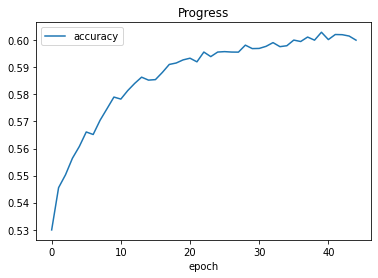

In [ ]:
plot_training_session(parameters, plots=["accuracy"])

In [ ]:
generate_name(model, parameters, start_char = 'j')
generate_name(model, parameters, start_char = 's')

('stil', {'gap': 1.1025908887386322, 'probability': 0.00012942787816918496})

In [ ]:
generate_name(model, parameters)

('flemarr', {'gap': 1.4284222573041916, 'probability': 1.6524365693330838e-07})

i=0 new_char: b (0.052) [best:  c (0.091), diff: 0.039, prob: 0.052, gap: 0.039]
i=1 new_char: l (0.087) [best:  e (0.431), diff: 0.344, prob: 0.004, gap: 0.383]
i=2 new_char: o (0.257) [best:  a (0.379), diff: 0.122, prob: 0.001, gap: 0.504]
i=3 new_char: n (0.972) [best:  n (0.972), diff: 0.000, prob: 0.001, gap: 0.504]
i=4 new_char: d (0.999) [best:  d (0.999), diff: 0.000, prob: 0.001, gap: 0.504]
i=5 new_char: i (0.241) [best:  e (0.483), diff: 0.242, prob: 0.000, gap: 0.746]
i=6 new_char: e (0.991) [best:  e (0.991), diff: 0.000, prob: 0.000, gap: 0.746]
i=7 new_char: * (1.000) [best:  * (1.000), diff: 0.000, prob: 0.000, gap: 0.746]
blondie (probs: 0.000269, gap: 0.745968)
('blondie', {'gap': 0.7459675595164299, 'probability': 0.0002685308476396237})


# Different RNN Types
Best performance was measured with LSTM and GRU types which where about 10% better than the simple rnn.


------------------------------SimpleRNN------------------------------
Epoch 1/10
1003/1003 [==============================] - 7s 6ms/step - loss: 1.5833 - accuracy: 0.5316
Epoch 2/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.4712 - accuracy: 0.5478
Epoch 3/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.4442 - accuracy: 0.5503
Epoch 4/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.4253 - accuracy: 0.5561
Epoch 5/10
1003/1003 [==============================] - 7s 7ms/step - loss: 1.4092 - accuracy: 0.5623
Epoch 6/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.3951 - accuracy: 0.5630
Epoch 7/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.3812 - accuracy: 0.5663
Epoch 8/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.3692 - accuracy: 0.5738
Epoch 9/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.3569 - accuracy: 0.5724
Epoch 10/10


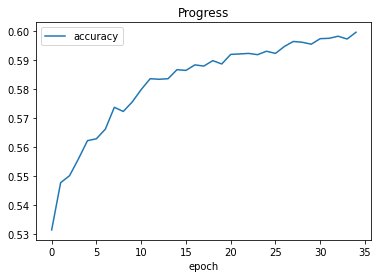

('jeadere', {'probability': 4.6736098264792685e-06, 'gap': 1.1506865620613098})
('tormand', {'probability': 3.6417991915244156e-05, 'gap': 0.7396034896373749})
------------------------------LSTM------------------------------
Epoch 1/10
1003/1003 [==============================] - 9s 5ms/step - loss: 1.6171 - accuracy: 0.5265
Epoch 2/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.4386 - accuracy: 0.5540
Epoch 3/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.3770 - accuracy: 0.5699
Epoch 4/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.3321 - accuracy: 0.5793
Epoch 5/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.2918 - accuracy: 0.5904
Epoch 6/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.2550 - accuracy: 0.6005
Epoch 7/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.2215 - accuracy: 0.6104
Epoch 8/10
1003/1003 [==============================] - 5s 5m

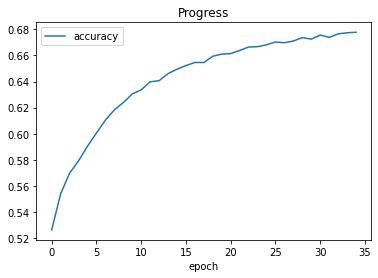

('joh', {'probability': 0.0005658068672269621, 'gap': 0.9337784945964813})
('serge', {'probability': 0.0003411372356750066, 'gap': 0.18778514862060547})
------------------------------GRU------------------------------
Epoch 1/10
1003/1003 [==============================] - 7s 5ms/step - loss: 1.6140 - accuracy: 0.5292
Epoch 2/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.4359 - accuracy: 0.5562
Epoch 3/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.3775 - accuracy: 0.5695
Epoch 4/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.3299 - accuracy: 0.5805
Epoch 5/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.2896 - accuracy: 0.5912
Epoch 6/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.2527 - accuracy: 0.6002
Epoch 7/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.2219 - accuracy: 0.6112
Epoch 8/10
1003/1003 [==============================] - 5s 5ms/step -

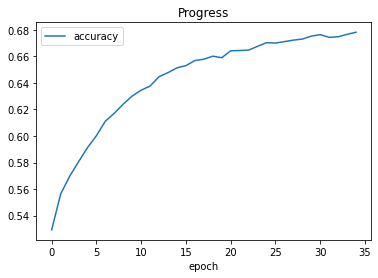

('jammai', {'probability': 0.00020839940905231408, 'gap': 0.8837475776672363})
('clay', {'probability': 0.0001469145841321824, 'gap': 0.6085929796099663})


In [ ]:
rnn_types = ['SimpleRNN', 'LSTM', 'GRU']
for rnn_type in rnn_types:
    print('-'*30 + rnn_type + '-'*30)
    parameters['rnn_type'] = rnn_type
    
    load_data(parameters)
    
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["history"] = {}

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )
    
    start = time.time()
    for i in range(len(parameters["epochs_to_run"])):
        train_model(model, parameters)
        parameters["iter"] = i
    end = time.time()
    print("Training took {0:.2f} seconds".format(end-start))
    
    plot_training_session(parameters, plots=["accuracy"])
    
    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))


# Different Number of Units
The best performance was measured with the most number of neurons, which is not surprising. But the difference in performance between 128 and 256 hidden units was not to big.

------------------------------GRU (32)------------------------------
Epoch 1/10
1003/1003 [==============================] - 6s 4ms/step - loss: 1.6452 - accuracy: 0.5246
Epoch 2/10
1003/1003 [==============================] - 4s 4ms/step - loss: 1.4566 - accuracy: 0.5502
Epoch 3/10
1003/1003 [==============================] - 4s 4ms/step - loss: 1.4024 - accuracy: 0.5657
Epoch 4/10
1003/1003 [==============================] - 4s 4ms/step - loss: 1.3639 - accuracy: 0.5747
Epoch 5/10
1003/1003 [==============================] - 4s 4ms/step - loss: 1.3350 - accuracy: 0.5806
Epoch 6/10
1003/1003 [==============================] - 4s 4ms/step - loss: 1.3104 - accuracy: 0.5863
Epoch 7/10
1003/1003 [==============================] - 4s 4ms/step - loss: 1.2885 - accuracy: 0.5939
Epoch 8/10
1003/1003 [==============================] - 4s 4ms/step - loss: 1.2705 - accuracy: 0.5975
Epoch 9/10
1003/1003 [==============================] - 4s 4ms/step - loss: 1.2522 - accuracy: 0.6031
Epoch 10/10
1

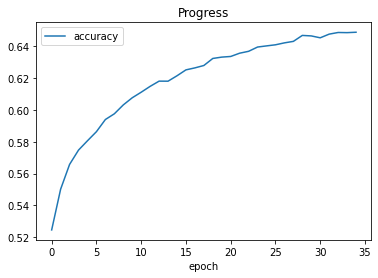

('jof', {'probability': 0.0005742318688115101, 'gap': 0.5717220306396484})
('giornato', {'probability': 5.7071452242856455e-06, 'gap': 0.4348199963569641})
------------------------------GRU (64)------------------------------
Epoch 1/10
1003/1003 [==============================] - 6s 4ms/step - loss: 1.6061 - accuracy: 0.5257
Epoch 2/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.4273 - accuracy: 0.5579
Epoch 3/10
1003/1003 [==============================] - 4s 4ms/step - loss: 1.3607 - accuracy: 0.5735
Epoch 4/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.3077 - accuracy: 0.5884
Epoch 5/10
1003/1003 [==============================] - 4s 4ms/step - loss: 1.2640 - accuracy: 0.5984
Epoch 6/10
1003/1003 [==============================] - 4s 4ms/step - loss: 1.2236 - accuracy: 0.6100
Epoch 7/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.1863 - accuracy: 0.6205
Epoch 8/10
1003/1003 [==============================] - 4s 4m

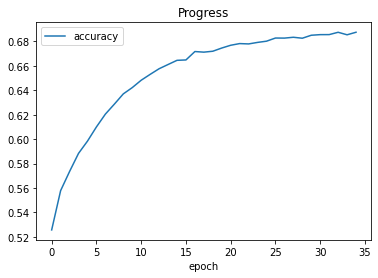

('jamus', {'probability': 0.0006319601530850109, 'gap': 0.664480447769165})
('rockweel', {'probability': 3.09123282786228e-05, 'gap': 0.6508563533425331})
------------------------------GRU (128)------------------------------
Epoch 1/10
1003/1003 [==============================] - 7s 5ms/step - loss: 1.5795 - accuracy: 0.5314
Epoch 2/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.4031 - accuracy: 0.5649
Epoch 3/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.3250 - accuracy: 0.5816
Epoch 4/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.2530 - accuracy: 0.6034
Epoch 5/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.1846 - accuracy: 0.6199
Epoch 6/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.1239 - accuracy: 0.6365
Epoch 7/10
1003/1003 [==============================] - 5s 5ms/step - loss: 1.0776 - accuracy: 0.6475
Epoch 8/10
1003/1003 [==============================] - 5s 5m

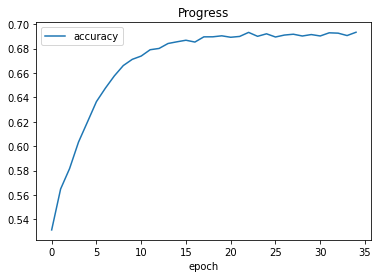

('jermaine', {'probability': 0.01471720063079186, 'gap': 0.141249880194664})
('regan', {'probability': 0.0008469501884482326, 'gap': 0.09638794511556625})
------------------------------GRU (256)------------------------------
Epoch 1/10
1003/1003 [==============================] - 8s 6ms/step - loss: 1.5723 - accuracy: 0.5352
Epoch 2/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.3959 - accuracy: 0.5631
Epoch 3/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.3023 - accuracy: 0.5893
Epoch 4/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.2155 - accuracy: 0.6109
Epoch 5/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.1388 - accuracy: 0.6305
Epoch 6/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.0718 - accuracy: 0.6485
Epoch 7/10
1003/1003 [==============================] - 6s 6ms/step - loss: 1.0215 - accuracy: 0.6630
Epoch 8/10
1003/1003 [==============================] - 6s 6m

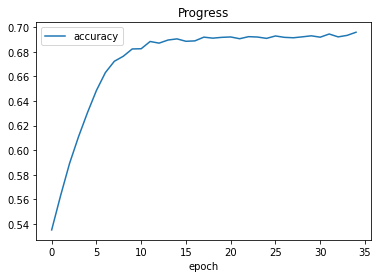

('julio', {'probability': 0.01153004303615867, 'gap': 0.30118316411972046})
('dominich', {'probability': 1.3386521585991197e-05, 'gap': 0.7663110345602036})


In [ ]:
import itertools

rnn_types = ['GRU']
rnn_units = [32, 64, 128, 256]


for index, (rnn_type, rnn_unit) in enumerate(itertools.product(rnn_types, rnn_units)):
    print('-'*30 + '{0} ({1})'.format(rnn_type, rnn_unit) + '-'*30)
    parameters['rnn_type'] = rnn_type
    parameters['rnn_units'] = [rnn_unit]
    
    load_data(parameters)
    
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["history"] = {}

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )
    
    start = time.time()
    for i in range(len(parameters["epochs_to_run"])):
        train_model(model, parameters)
        parameters["iter"] = i
    end = time.time()
    print("Training took {0:.2f} seconds".format(end-start))
    
    plot_training_session(parameters, plots=["accuracy"])
    
    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))


# Regularization
The best performance was measured when both dropout rates were taken with a small value. This is as well not surprising

------------------------------dropout: 0.2, recurrent dropout: 0.2------------------------------
Epoch 1/10
1003/1003 [==============================] - 17s 14ms/step - loss: 1.6499 - accuracy: 0.5207
Epoch 2/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.5001 - accuracy: 0.5423
Epoch 3/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.4463 - accuracy: 0.5531
Epoch 4/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.4094 - accuracy: 0.5622
Epoch 5/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.3793 - accuracy: 0.5682
Epoch 6/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.3556 - accuracy: 0.5738
Epoch 7/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.3365 - accuracy: 0.5781
Epoch 8/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.3216 - accuracy: 0.5822
Epoch 9/10
1003/1003 [==============================] - 14s 14ms/step -

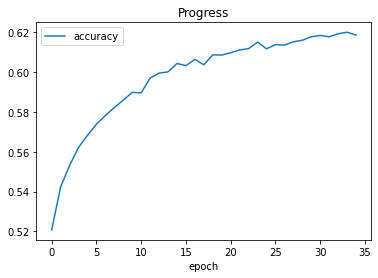

('jessey', {'probability': 0.002047416912362677, 'gap': 0.3365044891834259})
('ignaz', {'probability': 3.9912797004541615e-05, 'gap': 0.7654635906219482})
------------------------------dropout: 0.2, recurrent dropout: 0.5------------------------------
Epoch 1/10
1003/1003 [==============================] - 16s 14ms/step - loss: 1.6599 - accuracy: 0.5177
Epoch 2/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.5141 - accuracy: 0.5384
Epoch 3/10
1003/1003 [==============================] - 15s 14ms/step - loss: 1.4680 - accuracy: 0.5482
Epoch 4/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.4410 - accuracy: 0.5534
Epoch 5/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.4173 - accuracy: 0.5584
Epoch 6/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.4026 - accuracy: 0.5641
Epoch 7/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.3897 - accuracy: 0.5665
Epoch 8/10
1003/1003

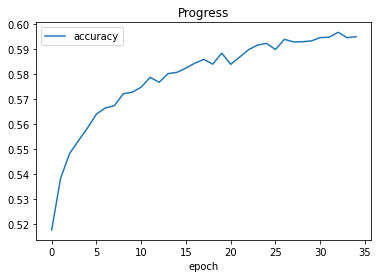

('juster', {'probability': 0.0007021861802783366, 'gap': 0.41349008679389954})
('giodly', {'probability': 1.4099083669684856e-08, 'gap': 0.9045241624116898})
------------------------------dropout: 0.5, recurrent dropout: 0.2------------------------------
Epoch 1/10
1003/1003 [==============================] - 16s 14ms/step - loss: 1.7455 - accuracy: 0.5063
Epoch 2/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.6132 - accuracy: 0.5232
Epoch 3/10
1003/1003 [==============================] - 15s 15ms/step - loss: 1.5779 - accuracy: 0.5292
Epoch 4/10
1003/1003 [==============================] - 15s 14ms/step - loss: 1.5564 - accuracy: 0.5325
Epoch 5/10
1003/1003 [==============================] - 15s 14ms/step - loss: 1.5429 - accuracy: 0.5359
Epoch 6/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.5303 - accuracy: 0.5391
Epoch 7/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.5234 - accuracy: 0.5399
Epoch 8/10
1003/1

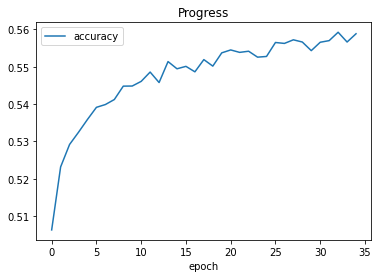

('jotowor', {'probability': 4.501086174769746e-08, 'gap': 1.4683305621147156})
('barracky', {'probability': 1.3184503260754445e-08, 'gap': 1.3290583789348602})
------------------------------dropout: 0.5, recurrent dropout: 0.5------------------------------
Epoch 1/10
1003/1003 [==============================] - 16s 14ms/step - loss: 1.7576 - accuracy: 0.5039
Epoch 2/10
1003/1003 [==============================] - 15s 15ms/step - loss: 1.6236 - accuracy: 0.5214
Epoch 3/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.5930 - accuracy: 0.5271
Epoch 4/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.5727 - accuracy: 0.5266
Epoch 5/10
1003/1003 [==============================] - 15s 14ms/step - loss: 1.5587 - accuracy: 0.5336
Epoch 6/10
1003/1003 [==============================] - 14s 14ms/step - loss: 1.5486 - accuracy: 0.5352
Epoch 7/10
1003/1003 [==============================] - 15s 14ms/step - loss: 1.5415 - accuracy: 0.5370
Epoch 8/10
1003

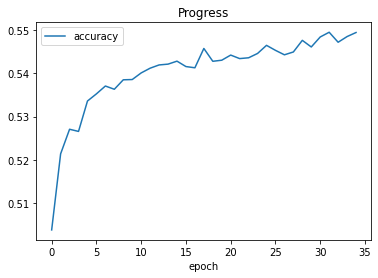

('jab', {'probability': 0.0010386376667663626, 'gap': 0.27661701291799545})
('kerard', {'probability': 7.972585594054824e-06, 'gap': 0.1842576563358307})


In [ ]:
dropout_rates = [0.2, 0.5]
rnn_dropout_rates = [0.2, 0.5]

# use the same model, but change the regularization
parameters['rnn_type'] = 'LSTM'
parameters['rnn_units'] = [128]

for index, (dropout, recurrent_dropout) in enumerate(itertools.product(dropout_rates, rnn_dropout_rates)):
    print('-'*30 + 'dropout: {0}, recurrent dropout: {1}'.format(dropout, recurrent_dropout) + '-'*30)
    parameters['dropout'] = dropout
    parameters['recurrent_dropout'] = recurrent_dropout

    load_data(parameters)
    
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["history"] = {}

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )
    
    start = time.time()
    for i in range(len(parameters["epochs_to_run"])):
        train_model(model, parameters)
        parameters["iter"] = i
    end = time.time()
    print("Training took {0:.2f} seconds".format(end-start))
    
    plot_training_session(parameters, plots=["accuracy"])
    
    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))

# Stacking RNNs
Best performance was measured while using only two layers instead of four. This is not suprising as the model has more parameters to learn. But training was much slower, as the rnns are not able to run directly on gpu (see error message). 

------------------------------stack: 2--------------------
Epoch 1/10
1003/1003 [==============================] - 21s 17ms/step - loss: 1.6538 - accuracy: 0.5184
Epoch 2/10
1003/1003 [==============================] - 17s 17ms/step - loss: 1.4612 - accuracy: 0.5475
Epoch 3/10
1003/1003 [==============================] - 17s 17ms/step - loss: 1.3918 - accuracy: 0.5694
Epoch 4/10
1003/1003 [==============================] - 18s 18ms/step - loss: 1.3338 - accuracy: 0.5819
Epoch 5/10
1003/1003 [==============================] - 18s 18ms/step - loss: 1.2902 - accuracy: 0.5902
Epoch 6/10
1003/1003 [==============================] - 17s 17ms/step - loss: 1.2483 - accuracy: 0.6001
Epoch 7/10
1003/1003 [==============================] - 17s 16ms/step - loss: 1.2164 - accuracy: 0.6089
Epoch 8/10
1003/1003 [==============================] - 16s 16ms/step - loss: 1.1900 - accuracy: 0.6156
Epoch 9/10
1003/1003 [==============================] - 17s 17ms/step - loss: 1.1683 - accuracy: 0.6209
Epoch

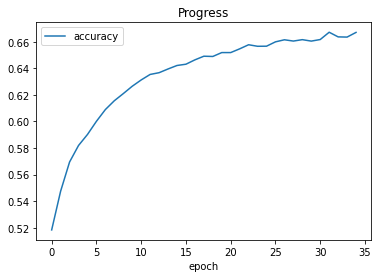

('jeb', {'probability': 0.005580849129053725, 'gap': 0.2442563772201538})
('berks', {'probability': 2.3945292586382225e-05, 'gap': 0.6674184091389179})
------------------------------stack: 4--------------------
Epoch 1/10
1003/1003 [==============================] - 37s 32ms/step - loss: 1.7384 - accuracy: 0.5005
Epoch 2/10
1003/1003 [==============================] - 33s 32ms/step - loss: 1.5628 - accuracy: 0.5239
Epoch 3/10
1003/1003 [==============================] - 32s 32ms/step - loss: 1.5001 - accuracy: 0.5365
Epoch 4/10
1003/1003 [==============================] - 32s 32ms/step - loss: 1.4568 - accuracy: 0.5487
Epoch 5/10
1003/1003 [==============================] - 32s 32ms/step - loss: 1.4222 - accuracy: 0.5569
Epoch 6/10
1003/1003 [==============================] - 32s 32ms/step - loss: 1.3851 - accuracy: 0.5669
Epoch 7/10
1003/1003 [==============================] - 32s 32ms/step - loss: 1.3483 - accuracy: 0.5753
Epoch 8/10
1003/1003 [==============================] - 33s 3

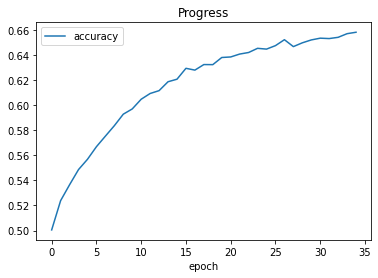

('jermain', {'probability': 0.0013103196861386835, 'gap': 0.6562483906745911})
('donomon', {'probability': 8.670064950891121e-08, 'gap': 1.6749938279390335})


In [9]:
stacks = [2, 4]
base_unit = [64]

parameters['rnn_type'] = 'GRU'
parameters['dropout'] = 0.0
parameters['recurrent_dropout'] = 0.2

for index, stack in enumerate(stacks):
    print('-'*30 + 'stack: {0}'.format(stack) + '-'*20)
    parameters['rnn_units'] = base_unit * stack
    
    load_data(parameters)
    
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["history"] = {}

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )

    start = time.time()
    for i in range(len(parameters["epochs_to_run"])):
        train_model(model, parameters)
        parameters["iter"] = i
    end = time.time()
    print("Training took {0:.2f} seconds".format(end-start))
    
    plot_training_session(parameters, plots=["accuracy"])
    
    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))